In [1]:
import numpy as np
import time, torch
import torch.nn.functional as F
from collections import OrderedDict
from torch import nn, optim
from torchvision import datasets, transforms
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
# Download and load the training data
trainset = datasets.MNIST('/home/yungshun/workspace/py3/pytorch-mnist-dnn-classifier/datasets/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

We'll build a network with `nn.Sequential` here. Only difference from the last part is we're not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [3]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_sizes[0])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
    ('relu2', nn.ReLU()),
    ('logits', nn.Linear(hidden_sizes[1], output_size))
]))

Define the loss function. In PyTorch, you'll usually see this as criterion. 
Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` 
as our loss. Later when training, you use `loss = criterion(output, targets)` 
to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along 
those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network 
parameters and the learning rate.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

The general process with PyTorch:
1. Make a forward pass through the network to get the logits 
2. Use the logits to calculate the loss
3. Perform a backward pass through the network with `loss.backward()` to calculate the gradients
4. Take a step with the optimizer to update the weights

In [5]:
print('Initial weights -', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights - Parameter containing:
tensor([[-0.0163, -0.0299, -0.0349,  ...,  0.0347, -0.0252, -0.0058],
        [-0.0186, -0.0143,  0.0088,  ..., -0.0062, -0.0316,  0.0136],
        [ 0.0213,  0.0053, -0.0127,  ...,  0.0154, -0.0284, -0.0277],
        ...,
        [ 0.0081,  0.0004, -0.0207,  ..., -0.0252,  0.0056, -0.0110],
        [ 0.0112,  0.0079,  0.0223,  ...,  0.0086,  0.0063, -0.0308],
        [-0.0145, -0.0104,  0.0213,  ..., -0.0227, -0.0254,  0.0206]],
       requires_grad=True)
Gradient - tensor([[-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [ 0.0001,  0.0001,  0.0001,  ...,  0.0001,  0.0001,  0.0001],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])


In [6]:
print('Updated weights -', model.fc1.weight)

Updated weights - Parameter containing:
tensor([[-0.0163, -0.0299, -0.0349,  ...,  0.0347, -0.0252, -0.0058],
        [-0.0186, -0.0143,  0.0088,  ..., -0.0062, -0.0316,  0.0136],
        [ 0.0213,  0.0053, -0.0127,  ...,  0.0154, -0.0284, -0.0277],
        ...,
        [ 0.0081,  0.0004, -0.0207,  ..., -0.0252,  0.0056, -0.0110],
        [ 0.0112,  0.0079,  0.0223,  ...,  0.0086,  0.0063, -0.0308],
        [-0.0145, -0.0104,  0.0213,  ..., -0.0227, -0.0254,  0.0206]],
       requires_grad=True)


In [7]:
# Train for real
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [8]:
epochs = 3
print_every = 40
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/3...  Loss: 2.2964
Epoch: 1/3...  Loss: 2.2726
Epoch: 1/3...  Loss: 2.2571
Epoch: 1/3...  Loss: 2.2348
Epoch: 1/3...  Loss: 2.2124
Epoch: 1/3...  Loss: 2.1885
Epoch: 1/3...  Loss: 2.1672
Epoch: 1/3...  Loss: 2.1336
Epoch: 1/3...  Loss: 2.1083
Epoch: 1/3...  Loss: 2.0717
Epoch: 1/3...  Loss: 2.0352
Epoch: 1/3...  Loss: 1.9902
Epoch: 1/3...  Loss: 1.9548
Epoch: 1/3...  Loss: 1.8951
Epoch: 1/3...  Loss: 1.8589
Epoch: 1/3...  Loss: 1.7927
Epoch: 1/3...  Loss: 1.7488
Epoch: 1/3...  Loss: 1.6761
Epoch: 1/3...  Loss: 1.6230
Epoch: 1/3...  Loss: 1.5471
Epoch: 1/3...  Loss: 1.4765
Epoch: 1/3...  Loss: 1.4350
Epoch: 1/3...  Loss: 1.3655
Epoch: 2/3...  Loss: 0.7088
Epoch: 2/3...  Loss: 1.2300
Epoch: 2/3...  Loss: 1.1742
Epoch: 2/3...  Loss: 1.1280
Epoch: 2/3...  Loss: 1.0631
Epoch: 2/3...  Loss: 1.0379
Epoch: 2/3...  Loss: 0.9702
Epoch: 2/3...  Loss: 0.9312
Epoch: 2/3...  Loss: 0.8763
Epoch: 2/3...  Loss: 0.8726
Epoch: 2/3...  Loss: 0.8394
Epoch: 2/3...  Loss: 0.7997
Epoch: 2/3...  Loss:

In [12]:
import matplotlib.pyplot as plt

In [13]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

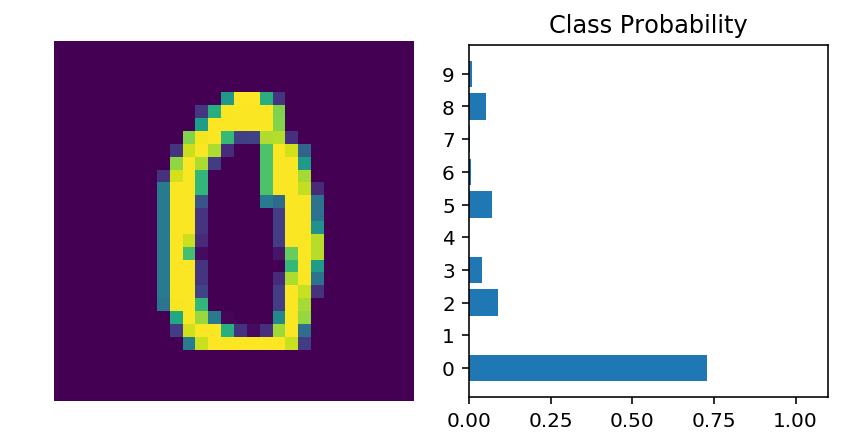

In [14]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)